In [10]:
# %load "../../style.py"
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit

sns.set(style='ticks', palette='Set2') 
sns.despine()

# These are the colors. Notice how this is programmed:
# You initialize your colors by 
# colorset = palette()
# then you can cycle through the colors:
# color = next(colorset)
# if you want your set to be reset, just create
# a new palette() instance! This way the colors do not interfere.

color_names = ['windows blue', "pale red", "faded green", "amber", 
          'dark green', 'dark fuchsia', 'browny orange', 
          'puke green', 'dark royal blue', 'dusty purple', 'red orange']
colors = sns.xkcd_palette(color_names)
palette = lambda: itertools.cycle(sns.xkcd_palette(color_names) )

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['axes.titlesize'] = fontsize_labels
xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  

save_fig = False
if not save_fig:
        rcParams['figure.figsize'] = (13, 8) 
fig_dir = "./figures/"  # directory of figures



In [11]:
# %load "../../preamb.py"
import numpy as np
import uncertainties as uc
import uncertainties.unumpy as un
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter as sav
from scipy.special import erfc
from scipy.integrate import quad
import sys

npy_dir = "./data_npy/"


/usr/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


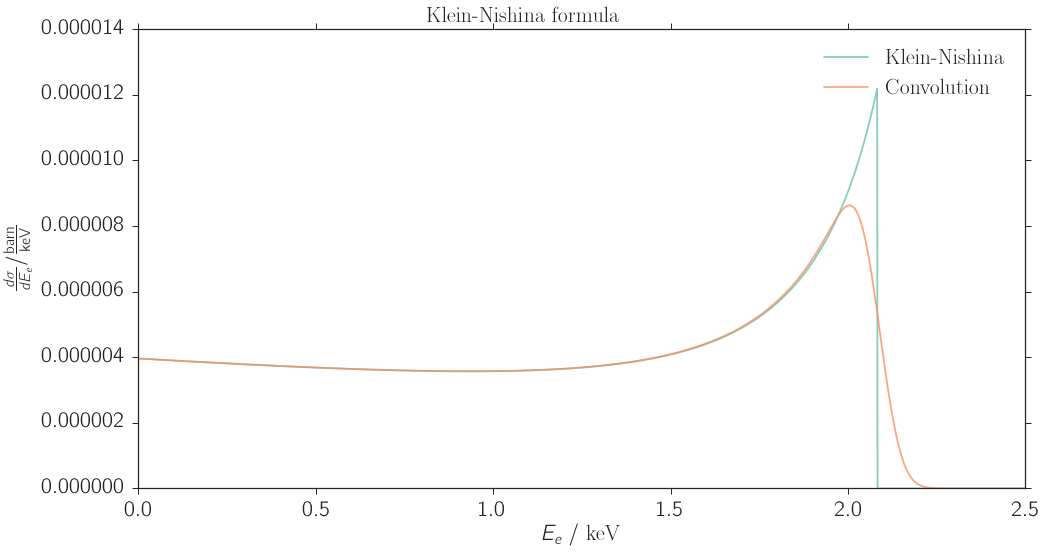

In [12]:
"""
Draws the Klein-Nishina formula
"""

import numpy as np
import pylab as plt
from matplotlib import rcParams
from scipy.optimize import curve_fit
import scipy.constants as co
#import uncertainties as uc
#import uncertainties.unumpy as un
from scipy.signal import argrelextrema as ext
import seaborn as sns

fontsize_labels = 22    # size used in latex document
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['text.usetex'] = True
rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['figure.figsize'] = (2*6.2, 2*3.83)  # in inches; width corresponds to \textwidth in latex document (golden ratio)

plt.close("all")
show_fig = True
save_fig = False # see below
if not save_fig:
    rcParams['figure.figsize'] = (15, 8)  # in inches; width corresponds to \textwidth in latex document (golden ratio)
fig_dir = "../figures/"
npy_dir = "./data_npy/"

def klein_nishina(x, a, C):
    """
    Insert photon and electron energy in m_e, constant C (in barn)
    """
    x_max = 2 * a**2 / (1 + 2 * a)                     # maximal electron energy
    dsdE =  C / a**2 * \
            (x**2 / (a * (a - x))**2 + ((x - 1)**2 - 1) / (a * (a - x)) + 2) *\
            (x <= x_max)                                     # in barn / keV
    dsdE[np.isnan(dsdE)] = 0
    return(dsdE)

def gauss(x, *p):
    mu, sigma = p
    return  1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-(x - mu)**2 / (2. * sigma**2))

def smeared_kn():
    '''
    convolve gaussian and Klein-Nishina
    starting at 0 - bound
    stopping at E_photon + bound
    (try 10 * sigma as bound)
    number of steps to be defined!
    '''
    smeared_kn = np.convolve(klein_nishina(x, E_photon), gauss(x, E_photon / 2, sigma), 'same')
    return smeared_kn

# Physics
E_photon    = 1277 # in keV
m_e = co.physical_constants["electron mass energy equivalent in MeV"][0] * 10**3 # in keV / c**2
lamb_e = co.physical_constants["Compton wavelength"][0] * 10**14    # Compton wavelength of electron in sqrt(barn)
C = co.alpha**2 * lamb_e**2 / (16 * np.pi**3 * m_e)                 # constant prefactor in barn / keV
#C = 1
a = E_photon / m_e
x_max = 2 * a**2 / (1 + 2 * a)                     # maximal electron energy

# Parameters of convolution
sigma  = 0.05
mu = 0
x0 = 2 * a
n_x = 10000
x = np.linspace(-x0, x0, n_x)

kn = klein_nishina(x, a, C)
g = gauss(x, mu, sigma)
smeared_kn = np.convolve(klein_nishina(x, a, C), gauss(x, mu, sigma), 'same') * 2 * x0 / n_x

#Plotting
fig1, ax1 = plt.subplots(1, 1)
if not save_fig:
    fig1.suptitle("Klein-Nishina formula")
ax1.plot(x, kn, '-', alpha=0.8, label=('Klein-Nishina'))
#ax1.plot(x, C * g, '-', alpha=0.8, label=('Gauss'))
ax1.plot(x, smeared_kn, '-', alpha=0.8, label=('Convolution'))
ax1.set_xlim(0, a)
#ax1.set_ylim(0, 3)
ax1.set_xlabel("$E_e$ / keV")
ax1.set_ylabel("$\\frac{d\sigma}{d E_e} / \mathrm{\\frac{barn}{keV}}$")
ax1.legend(loc=1)
if show_fig:
    fig1.show()
if save_fig:
    file_name = "klein_nishina"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


